In [1]:
import numpy as np 
import pandas as pd

import os

import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt

import pathlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model
import seaborn as sn

from sklearn.metrics import accuracy_score, confusion_matrix
import sklearn

%matplotlib inline

# Data

#### Image Count

In [2]:
input_path = "/kaggle/input/kermany2018/OCT2017 /"

def get_image_count(input_path, path_list=['train', 'test', 'val']):
    for _set in path_list:
        normal = len(os.listdir(input_path + _set + '/NORMAL'))
        dme = len(os.listdir(input_path + _set + '/DME'))
        drusen = len(os.listdir(input_path + _set + '/DRUSEN'))
        cnv = len(os.listdir(input_path + _set + '/CNV'))
        total = normal + dme + drusen + cnv
        print(f"{_set}:")
        print(f"     Normal images: {normal}")       
        print(f"     DME images: {dme}")
        print(f"     DRUSEN images: {drusen}")
        print(f"     CNV images: {cnv}")
        print(f"     Total images: {total}")  

In [3]:
get_image_count(input_path, path_list=['train', 'test'])

train:
     Normal images: 26315
     DME images: 11348
     DRUSEN images: 8616
     CNV images: 37205
     Total images: 83484
test:
     Normal images: 242
     DME images: 242
     DRUSEN images: 242
     CNV images: 242
     Total images: 968


In [4]:
train_data_dir = "../input/kermany2018/OCT2017 /train"
train_data_dir = pathlib.Path(train_data_dir)

val_data_dir = "../input/kermany2018/OCT2017 /val"
val_data_dir = pathlib.Path(val_data_dir)
print(train_data_dir,"\n", val_data_dir)

../input/kermany2018/OCT2017 /train 
 ../input/kermany2018/OCT2017 /val


In [5]:
train_image_count = len(list(train_data_dir.glob('*/*.jpeg')))
print("Training Image Count:", train_image_count)

# val_image_count = len(list(val_data_dir.glob('*/*.jpeg')))
# print("Validation Image Count:", val_image_count)

Training Image Count: 83484


In [6]:
temp = list(train_data_dir.glob("*"))
class_names = [str(x).split("/")[-1] for x in temp]
class_names = np.array(class_names)
print("Class Names:", class_names)

Class Names: ['DRUSEN' 'CNV' 'NORMAL' 'DME']


In [7]:
BATCH_SIZE = 32
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_SHAPE = (IMG_HEIGHT,IMG_WIDTH,3)
IMG_DIMS = [IMG_HEIGHT, IMG_WIDTH]

# EDA

In [8]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255,
                                                                     zoom_range = 0.3,
                                                                     horizontal_flip = True,
                                                                     validation_split=0.1)

In [9]:
train_data_gen = image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=IMG_DIMS,
                                                     subset="training"
                                                     )

Found 75138 images belonging to 4 classes.


In [10]:
val_data_gen = image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     subset="validation",
                                                     target_size=IMG_DIMS,
                                                     )

Found 8346 images belonging to 4 classes.


In [11]:
train_data_gen.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

In [12]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(class_names[label_batch[n]==1][0])
        plt.axis('off')

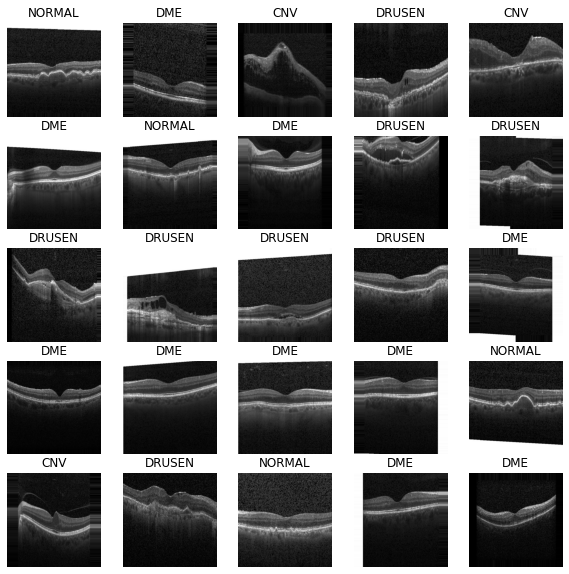

In [13]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

# Data Preparation

In [14]:
def get_train_val_data(train_data_dir,val_data_dir, img_dims, batch_size):
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255,
                                                                     zoom_range = 0.3,
                                                                     horizontal_flip = True,
                                                                     validation_split=0.1)
    
    train_data_gen = image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=batch_size,
                                                     shuffle=True,
                                                     target_size=(img_dims, img_dims),
                                                         subset="training"
                                                     )
    
    val_data_gen = image_generator.flow_from_directory(directory=str(train_data_dir),
                                                     batch_size=batch_size,
                                                     shuffle=False,
                                                     subset="validation",
                                                     target_size=(img_dims, img_dims),
                                                     )
    
    
    return train_data_gen, val_data_gen

In [15]:
# params for training purpose
IMG_DIMS = 160
IMG_SHAPE = [IMG_DIMS, IMG_DIMS, 3]
epochs = 10
BATCH_SIZE = 128

In [16]:
# get training and val data
train_gen, val_gen = get_train_val_data(train_data_dir,val_data_dir, 
                                         IMG_DIMS, BATCH_SIZE)

Found 75138 images belonging to 4 classes.
Found 8346 images belonging to 4 classes.


# Build The Model

In [17]:
inputs = Input(shape=IMG_SHAPE)

# 1st convolution block
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# 2nd convolution block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# 3rd convolution block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# 4th convolution block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# 5th convolution block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Dropout(rate=0.2)(x)

# Fully Connected layers
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(rate=0.3)(x)

# Output layer
output = Dense(units=4, activation='softmax')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.h5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

2021-12-01 20:16:09.909634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 20:16:10.024101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 20:16:10.024853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 20:16:10.026117: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 160, 160, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 80, 80, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 80, 80, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 80, 32)        128   

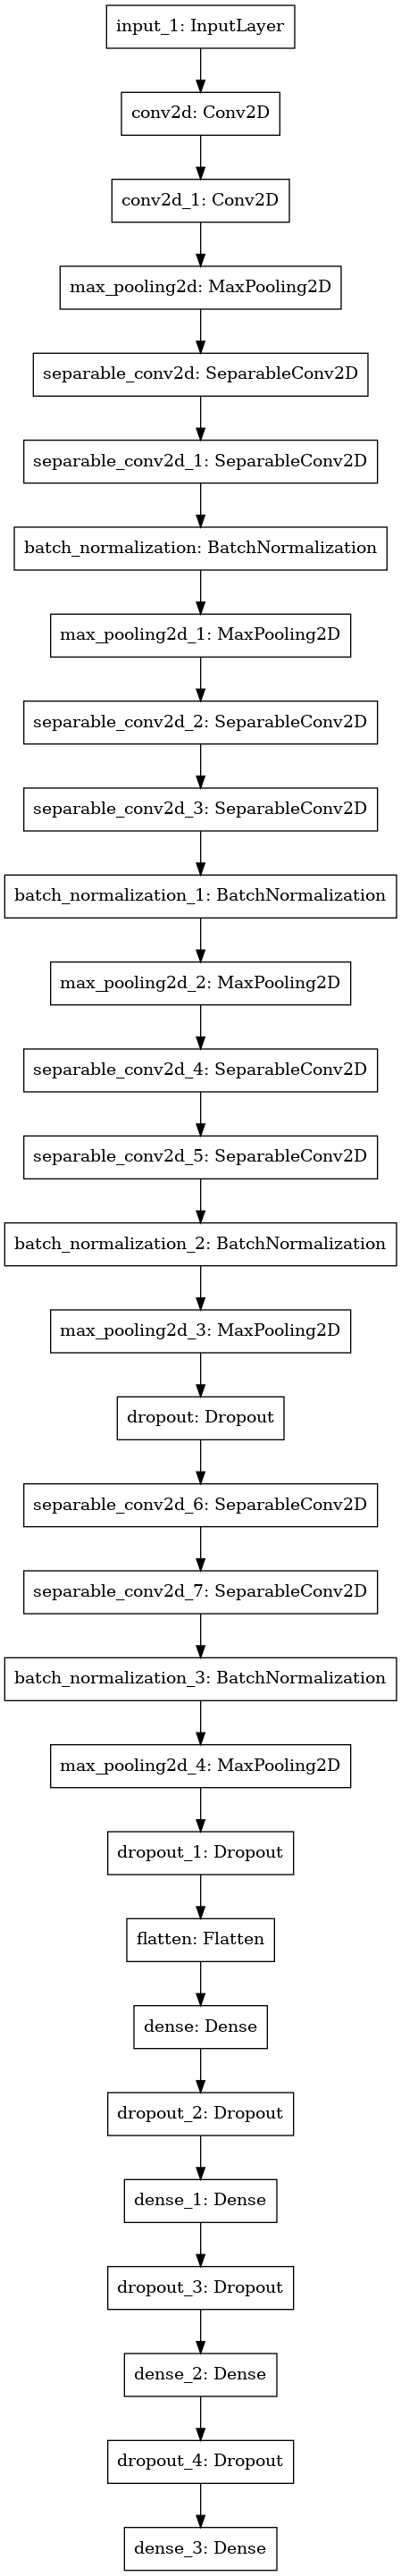

In [19]:
# using keras func to plot the model arch.
plot_model(model)

In [20]:
train_gen.samples, val_gen.samples

(75138, 8346)

## Training

In [21]:
history = model.fit(
                    train_gen, 
                    steps_per_epoch=train_gen.samples // BATCH_SIZE, 
                    epochs=epochs,
                    validation_data=val_gen, 
                    validation_steps=val_gen.samples // BATCH_SIZE,
                    callbacks=[checkpoint, lr_reduce]
                    )

2021-12-01 20:16:15.817355: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-12-01 20:16:19.665140: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


587/587 [==============================] - 1096s 2s/step - loss: 0.6811 - accuracy: 0.7516 - val_loss: 1.3271 - val_accuracy: 0.1674
Epoch 2/10
587/587 [==============================] - 740s 1s/step - loss: 0.4044 - accuracy: 0.8644 - val_loss: 0.4171 - val_accuracy: 0.8459
Epoch 3/10
587/587 [==============================] - 748s 1s/step - loss: 0.3148 - accuracy: 0.8985 - val_loss: 1.1778 - val_accuracy: 0.5802

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/10
587/587 [==============================] - 747s 1s/step - loss: 0.2501 - accuracy: 0.9187 - val_loss: 0.2707 - val_accuracy: 0.9078
Epoch 5/10
587/587 [==============================] - 748s 1s/step - loss: 0.2343 - accuracy: 0.9248 - val_loss: 0.2308 - val_accuracy: 0.9225

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/10
587/587 [==============================] - 746s 1s/step - loss: 0.2135 - accuracy: 0.9312 - val_loss: 0.2424 - val_accurac

In [22]:
model.save('cmpe_272_a3_v1.h5')

## Results

In [23]:
print ('Train Accuracy', history.history['accuracy'][-1])
print ('Train Loss', history.history['loss'][-1])
print ('\nValidation Accuracy', history.history['val_accuracy'][-1])
print ('Validation Loss', history.history['val_loss'][-1])

Train Accuracy 0.9352619647979736
Train Loss 0.19948121905326843

Validation Accuracy 0.9228365421295166
Validation Loss 0.22659596800804138


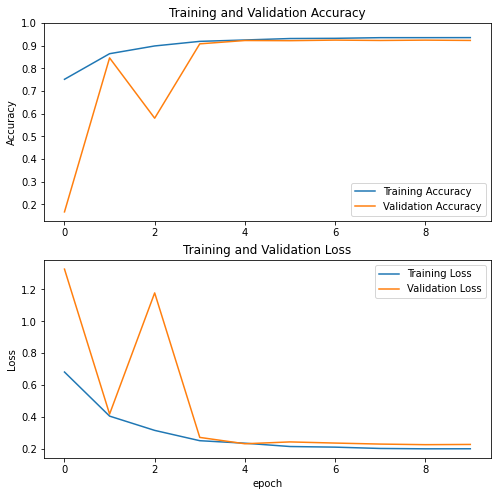

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss,label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Inference

In [25]:
# model = tf.keras.models.load_model("../input/cmpe-272-a2/cmpe_272_a2_v2.h5")

In [26]:
test_data_dir = "../input/kermany2018/OCT2017 /test"
test_data_dir = pathlib.Path(test_data_dir)

test_image_count = len(list(test_data_dir.glob('*/*.jpeg')))
print("Test Image Count:", test_image_count)

Test Image Count: 968


In [27]:
get_image_count(input_path, ['test'])

test:
     Normal images: 242
     DME images: 242
     DRUSEN images: 242
     CNV images: 242
     Total images: 968


In [28]:
test_images_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
    
test_data_gen = image_generator.flow_from_directory(directory=str(test_data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     target_size=(IMG_DIMS, IMG_DIMS)
                                                     )

Found 968 images belonging to 4 classes.


In [29]:
i = 0
total_batches = test_data_gen.samples//BATCH_SIZE

y_true = []    
y_pred = []
    
    
for test_images, labels in test_data_gen:
    if i>total_batches:
        break
    i+=1 
    print(f"Batch - {i}")
    temp_pred = model.predict(test_images)
    
    true_lables = [np.argmax(x) for x in labels]
    pred_lables = [np.argmax(x) for x in temp_pred]
    
#     y_pred.append(pred_lables)
#     y_true.append(true_lables)
    y_true = y_true + true_lables    
    y_pred = y_pred + pred_lables

Batch - 1
Batch - 2
Batch - 3
Batch - 4
Batch - 5
Batch - 6
Batch - 7
Batch - 8


In [30]:
print("Accuracy of model =",accuracy_score(y_true, y_pred))

Accuracy of model = 0.9855371900826446


In [31]:
def plot_confusion_matrix(y_true, y_pred, class_dict):
    cm = confusion_matrix(y_true, y_pred) 

    labels = set([class_dict[i] for i in y_true])
    labels = sorted(list(labels))
    df_cm = pd.DataFrame(cm, labels, labels)
    # df_cm = pd.DataFrame(cm, range(len(labels)), range(len(labels)))
    sn.set(font_scale=1.4)
    plt.figure(figsize=(6, 4))
    sn.heatmap(df_cm, annot=True, cmap='Blues', linecolor='black', linewidths=1,fmt="g")

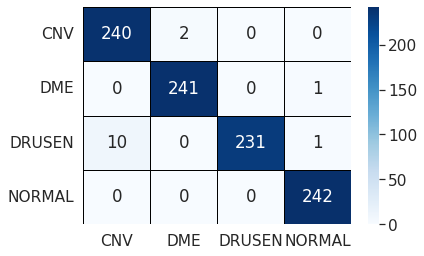

In [32]:
class_dict = dict([(v,k) for k,v in test_data_gen.class_indices.items()])
plot_confusion_matrix(y_true, y_pred, class_dict)

In [33]:
print(sklearn.metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       242
           1       0.99      1.00      0.99       242
           2       1.00      0.95      0.98       242
           3       0.99      1.00      1.00       242

    accuracy                           0.99       968
   macro avg       0.99      0.99      0.99       968
weighted avg       0.99      0.99      0.99       968

